In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import sys

sys.path.append(os.path.abspath("../../"))
from dataset import DS_NAMES
from dataset import DS_DIMENSIONS
from utilities.figure_tools import get_latest_results_directory, make_fig_directory, load_results

In [35]:
run_id, run_path = get_latest_results_directory("../../results/compare-methods/")
# run_id = 15
# run_path = "C:/Users/Peter/Documents/Peter/9-Graduate-School/dsrg/explainable-ad/code/HEEAD/results/vary-dim/run-015"
fig_output_path = make_fig_directory(run_id)
found_ds, results = load_results(run_path, group_field="explainer")

all_results = pd.DataFrame(columns=["dataset", "explainer", "n_samples", "n_features", "accuracy", "precision",
                               "recall", "f1", "avg_nnodes", "avg_nleaves", "avg_depth", "q", "jaccard", "coverage_ratio", "mean_distance", "mean_length", "runtime"])

for ds in found_ds:
    for index, row in results[ds].iterrows():
        row["dataset"] = ds
        all_results = all_results.append(row)

found_explainers = all_results["explainer"].unique()

print("Generating figures for run-{:03d}".format(run_id))
print("Datasets included:")
for ds in found_ds:
    print("\t", ds)
print("Explainers included:")
for expl in found_explainers:
    print("\t", expl)

Generating figures for run-005
Datasets included:
	 annthyroid
	 cardio
	 http
	 mulcross
	 musk
	 pendigits
	 satimage
	 shuttle
	 thyroid
	 wbc
Explainers included:
	 BestCandidate
	 GraphMerge


In [36]:
all_results.head()

,dataset,explainer,n_samples,n_features,accuracy,precision,recall,f1,avg_nnodes,avg_nleaves,avg_depth,q,jaccard,coverage_ratio,mean_distance,mean_length,runtime
0,annthyroid,BestCandidate,7200,6,0.982730,0.993023,0.988291,0.990648,134.06,67.53,14.14,0.949438,1.000000,1.000000,0.016900,1.593472,25.063037
1,annthyroid,GraphMerge,7200,6,0.982730,0.993023,0.988291,0.990648,134.06,67.53,14.14,0.949438,1.000000,1.000000,0.014140,1.406389,2.955860
0,cardio,BestCandidate,1831,21,0.984357,0.992044,0.990797,0.991403,43.72,22.36,9.19,0.890906,0.555309,0.911172,0.430570,2.078443,1.680113
1,cardio,GraphMerge,1831,21,0.984357,0.992044,0.990797,0.991403,43.72,22.36,9.19,0.890906,0.555309,1.000000,0.107014,1.572752,1.718805
0,http,BestCandidate,567498,3,0.999981,0.999984,0.999997,0.999991,25.92,13.46,5.88,0.979977,0.954737,1.000000,0.237386,1.531796,289.217157


In [37]:
cmap = plt.get_cmap("Set1")
colors = cmap.colors

In [38]:
all_results["sample_runtime"] = all_results["runtime"] / all_results["n_samples"] * 1000

In [39]:
all_results.head()

,dataset,explainer,n_samples,n_features,accuracy,precision,recall,f1,avg_nnodes,avg_nleaves,avg_depth,q,jaccard,coverage_ratio,mean_distance,mean_length,runtime,sample_runtime
0,annthyroid,BestCandidate,7200,6,0.982730,0.993023,0.988291,0.990648,134.06,67.53,14.14,0.949438,1.000000,1.000000,0.016900,1.593472,25.063037,3.480977
1,annthyroid,GraphMerge,7200,6,0.982730,0.993023,0.988291,0.990648,134.06,67.53,14.14,0.949438,1.000000,1.000000,0.014140,1.406389,2.955860,0.410536
0,cardio,BestCandidate,1831,21,0.984357,0.992044,0.990797,0.991403,43.72,22.36,9.19,0.890906,0.555309,0.911172,0.430570,2.078443,1.680113,0.917593
1,cardio,GraphMerge,1831,21,0.984357,0.992044,0.990797,0.991403,43.72,22.36,9.19,0.890906,0.555309,1.000000,0.107014,1.572752,1.718805,0.938725
0,http,BestCandidate,567498,3,0.999981,0.999984,0.999997,0.999991,25.92,13.46,5.88,0.979977,0.954737,1.000000,0.237386,1.531796,289.217157,0.509636


In [40]:
def render_bar_plot(xfeature, yfeature, xlabel, ylabel, title, save_name=None, xrange=None, yrange=None):
    fig, ax = plt.subplots()
    pos = np.arange(len(found_ds))
    bar_width = 0.4

    yvalues = all_results[yfeature].unique()

    for i in range(len(yvalues)):
        isExpl = all_results[yfeature] == yvalues[i]
        ax.barh(y=(pos + bar_width*i), width=all_results[isExpl][xfeature], height=bar_width)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(found_explainers,loc="best")
    plt.yticks(pos, found_ds)

    if save_name is not None:
        plt.savefig(fig_output_path + "/" + save_name)

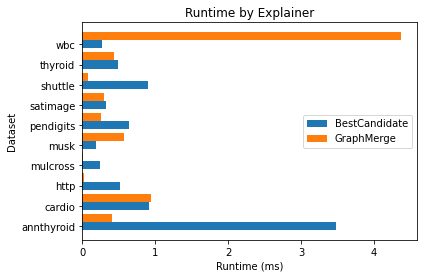

In [41]:
render_bar_plot("sample_runtime", "explainer", "Runtime (ms)", "Dataset", "Runtime by Explainer", "runtime.png")

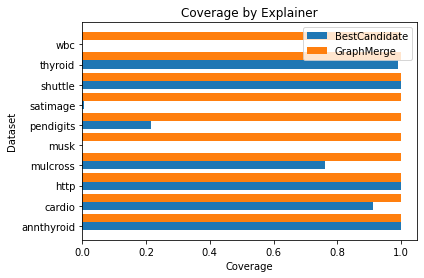

In [42]:
render_bar_plot("coverage_ratio", "explainer", "Coverage", "Dataset", "Coverage by Explainer", "coverage.png")

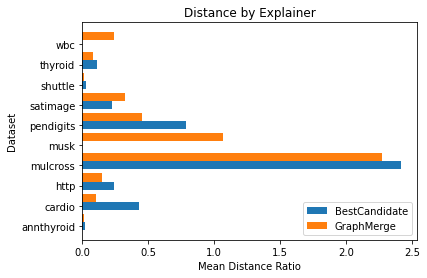

In [43]:
render_bar_plot("mean_distance", "explainer", "Mean Distance Ratio", "Dataset", "Distance by Explainer", "distance.png")

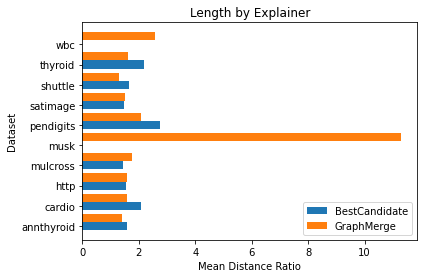

In [44]:
render_bar_plot("mean_length", "explainer", "Mean Distance Ratio", "Dataset", "Length by Explainer", "length.png")

In [45]:
fig_output_path

'run-005'

In [48]:
# Classification performance

md_table_path = fig_output_path + "/results.md"
f = open(md_table_path, "w")

metrics = ["f1", "avg_nnodes", "avg_nleaves", "avg_depth", "q", "jaccard"]
formats = ["{v:0.2f}", "{v:0.2f}", "{v:0.2f}", "{v:0.2f}", "{v:0.2f}", "{v:0.2f}"]

f.write("| dataset | n | p | f1 | nNodes | nLeaves | depth | Q | J |\n")
f.write("|---------|---|---|----|--------|---------|-------|---|---|\n")

for ds in found_ds:
    n = DS_DIMENSIONS[ds][0]
    p = DS_DIMENSIONS[ds][1]
    f.write("| {ds} | {n} | {p}".format(ds=ds, n=n, p=p))
    for i in range(len(metrics)):
        metric = metrics[i]
        isexpl = results[found_ds[0]]["explainer"] == found_explainers[0]
        val = results[ds][isexpl][metric].to_numpy()[0]
        f.write((" | " + "{v:0.2f}" + "").format(v=val))
    f.write(" |")
    f.write("\n")

# Explanation performance
f.write("\n\n")
metrics = ["coverage_ratio", "sample_runtime", "mean_length", "mean_distance"]
scales = [100, 1, 1, 100]
f.write("|            |       |     | AFT    | AFT    | AFT   | AFT  | FACET | FACET | FACET | FACET  |\n")
f.write("| ---------- | ----- | --- | ------ | ------ | ----- | ---- | ----- | ----- | ----- | ------ |\n")
f.write("| Dataset    | n     | p   | C      | C      | R     | R    | L     | L     | D     | D      |\n")

for ds in found_ds:
    n = DS_DIMENSIONS[ds][0]
    p = DS_DIMENSIONS[ds][1]
    f.write("| {ds} | {n} | {p}".format(ds=ds, n=n, p=p))
    for i in range(len(metrics)):
        metric = metrics[i]
        scale = scales[i]
        for explainer in found_explainers:
            isexpl = results[found_ds[0]]["explainer"] == explainer
            if metric == "sample_runtime":
               val = results[ds][isexpl]["runtime"].to_numpy()[0] / results[ds][isexpl]["n_samples"].to_numpy()[0] * 1000
            else:
                val = results[ds][isexpl][metric].to_numpy()[0]
            f.write(" | {v:0.2f}".format(v=val * scale))
    f.write(" |")
    f.write("\n")

f.close()